In [18]:
pip install rdkit pandas scikit-learn matplotlib seaborn lightgbm lazypredict tqdm pathlib tqdm lazypredict pathlib lightgbm


Note: you may need to restart the kernel to use updated packages.


In [19]:
# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder


Load and Explore the Data

Read the CSV file: Use pandas to read your dataset.

In [20]:
# Install all modules used in this project

# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import lazypredict
OneHotEncoder(handle_unknown="ignore", sparse_output=False)
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm
#from tqdm import tqdmcore


In [21]:
# Load the CSV file
file_path = 'CCS_smiles.csv'
df = pd.read_csv(file_path, quotechar='"',delimiter=',')
#read columns 
print(df.columns)


Index(['CCS', 'Molecular_Weight', 'LogP', 'H_Donors', 'H_Acceptors',
       'Rotatable_Bonds', 'SMILES'],
      dtype='object')


In [22]:
df = df.dropna()  # Optionally, drop rows with missing values

Now we want to check the data that we have as dataset for training and test sets

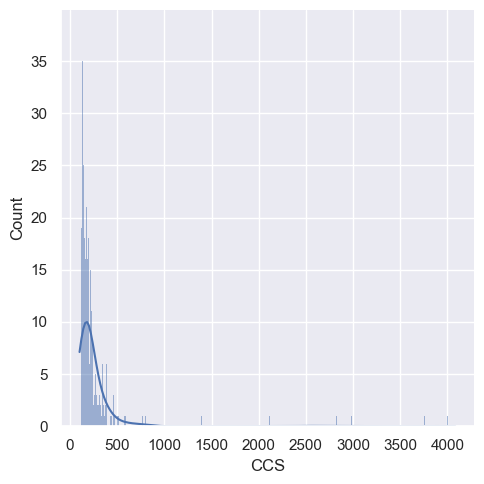

In [23]:
import seaborn as sn

sn.set_theme()
sn.displot(data=df, x="CCS", binwidth=1, kde=True)

As we only have small organic molecules we gonna filter the data to have a maximum of 500 Angström of CCS 

In [24]:
new_data_set = df[df.CCS.apply(lambda x: x > 90.0 and x < 250.0)]

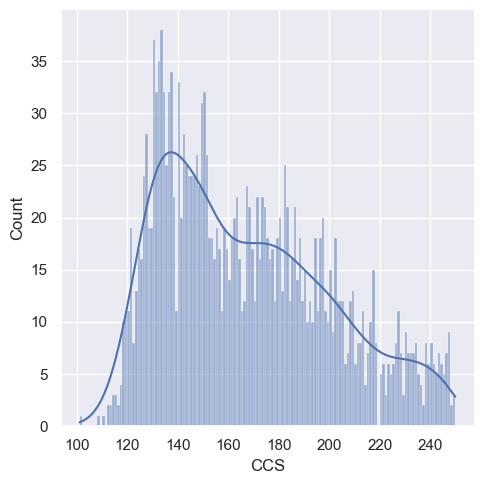

In [25]:
sn.displot(data=new_data_set, x="CCS", binwidth=1, kde=True)

In [26]:
new_data_set.to_csv('Data_Cleaned_CCS.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'Data_Cleaned_CCS.csv'

In [27]:
data_dl = 'Data_Cleaned_CCS.csv'

Calculate molecular descriptor and save it 

In [28]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from tqdm import tqdm
from rdkit import Chem

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(new_data_set['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:35<00:00, 56.74it/s]


In [29]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
1,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
2,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
3,13.92,13.92,0.12,-6.94,0.05,54.55,665.42,638.21,665.10,240,...,0,0,0,0,0,0,0,0,0,0
4,14.10,14.10,0.33,-7.12,0.06,55.50,745.43,715.19,745.09,266,...,0,0,0,0,0,0,0,0,0,0


Calculate molecular descriptors for the test data.

In [32]:
#load test data
data_dl = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')
Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:36<00:00, 55.06it/s]


save in .csv file

In [35]:
df_descriptors.to_csv('Data_descriptor.csv', index=False)
data_dl_descriptors.to_csv('Data_Test_descriptor.csv', index=False)

Make training and validation set

In [36]:
#data_dl = pd.read_csv('data_dl.csv', delimiter=',')
#data_dl= data_dl[data_dl['CCS'].apply(lambda x: x > 90.0 and x < 250.0)]
df_descriptors = pd.read_csv('Data_descriptor.csv', delimiter=',')
data_cleaned_final = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')
#data_dl_descriptors = pd.read_csv("Data_Test_descriptor.csv", delimiter=',')

Split the data for training and testing set

In [37]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

LazyRegressor

In [38]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

 98%|████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:23<00:00,  1.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18999
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 164
[LightGBM] [Info] Start training from score 167.908594


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:23<00:00,  1.79it/s]


In [39]:
prediction_tests[:1000]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,11972241317055288964653051934973224030195842809...,-6617821833548149846105464637365799691432335769...,25815642345742731636113408.00,0.07
RANSACRegressor,19113846816805046039085056.00,-1056544296406309173985280.00,32618895783050.49,0.45
SGDRegressor,5340387874.18,-295197318.62,545232.34,0.02
KernelRidge,502.70,-26.73,167.12,0.11
GaussianProcessRegressor,66.64,-2.63,60.45,0.79
DummyRegressor,19.35,-0.01,31.96,0.02
QuantileRegressor,19.14,-0.00,31.78,0.36
MLPRegressor,7.16,0.66,18.52,2.33
NuSVR,4.85,0.79,14.64,0.17


In [ ]:
#params = {'max_depth' : list(range(10, 20, 2)),
#          'n_estimators' : list(range(1100, 1300, 100)) ,
#          'learning_rate': list(np.arange(0.02, 0.04, 0.01))}

#grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=5, verbose=1)

#grid_search.fit(x_train, y_train)

#print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 750}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.009000000000000001, 'max_depth': 3, 'n_estimators': 700}

Model training and testing set

In [42]:
model = LGBMRegressor(n_estimators = 700,
                      max_depth = 3,
                      learning_rate = 0.009,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19000
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 164
[LightGBM] [Info] Start training from score 167.908594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [141]:
def plot_data(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted, y=actual, line_kws={"lw": 2, "ls": "--", "color": "red", "alpha": 0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted CCS", color="blue")
    plt.xlim(120, 250)
    plt.ylabel("Experimental CCS", color="blue")
    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

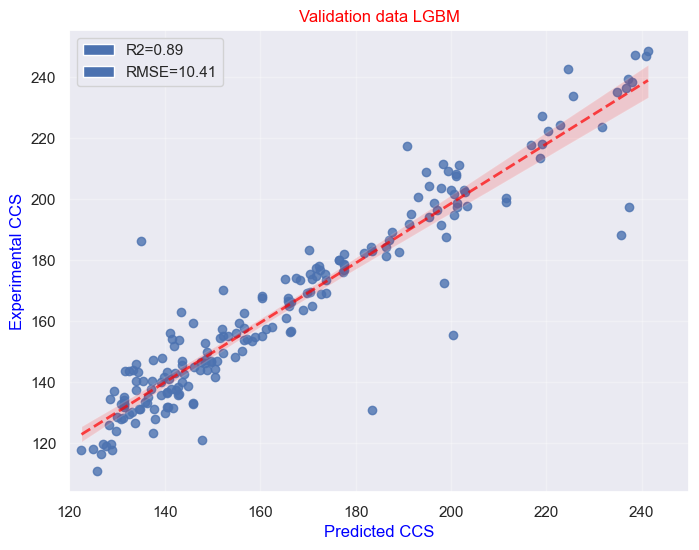

In [46]:
plot_data(y_valid, y_preds, "Validation data LGBM")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds})
data_to_save.to_csv('data_LGBM.csv', index=False)

# Features selections based on variance

In [64]:
from sklearn.feature_selection import VarianceThreshold

# Assume `data` is your dataset (DataFrame or numpy array)
selector = VarianceThreshold(threshold=0.1)  # Set a variance threshold
filtered_data = selector.fit_transform(df_descriptors)

# Get the column names that were retained
selected_columns = df_descriptors.columns[selector.get_support()]

# Create a new DataFrame with the retained columns
df_descriptors_variance_filtered = pd.DataFrame(filtered_data, columns=selected_columns)

# Save to a new .csv file
df_descriptors_variance_filtered.to_csv("df_descriptors_Variance_filtered.csv", index=False)


In [65]:
df_descriptors_variance_filtered

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_ester,fr_ether,fr_halogen,fr_imidazole,fr_ketone,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester
0,13.92,13.92,0.12,-6.94,54.55,665.42,638.21,665.10,240.00,1.11,...,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,2.00
1,13.92,13.92,0.12,-6.94,54.55,665.42,638.21,665.10,240.00,1.11,...,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,2.00
2,13.92,13.92,0.12,-6.94,54.55,665.42,638.21,665.10,240.00,1.11,...,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,2.00
3,13.92,13.92,0.12,-6.94,54.55,665.42,638.21,665.10,240.00,1.11,...,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,2.00
4,14.10,14.10,0.33,-7.12,55.50,745.43,715.19,745.09,266.00,1.12,...,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,3.00,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,7.83,7.83,0.01,-3.53,33.21,215.69,201.58,215.09,78.00,1.79,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1988,8.23,8.23,0.15,-4.04,35.25,241.36,222.21,241.14,90.00,1.69,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1989,8.40,8.40,0.47,-3.66,65.33,162.24,148.12,162.12,64.00,1.83,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1990,10.69,10.69,0.10,-2.97,20.60,137.14,130.08,137.05,52.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [70]:
x_train_variance_filtered, x_valid_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered = train_test_split(df_descriptors_variance_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_variance_filtered)
x_train_scaled_variance_filtered = scaler.transform(x_train_variance_filtered)
x_valid_scaled_variance_filtered = scaler.transform(x_valid_variance_filtered)

In [71]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_variance_filtered, x_valid_scaled_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:18<00:00,  2.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16401
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 139
[LightGBM] [Info] Start training from score 167.908594


In [72]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.68,0.91,9.61,2.10
ExtraTreesRegressor,0.68,0.91,9.66,2.27
LGBMRegressor,0.67,0.91,9.77,0.20
HistGradientBoostingRegressor,0.67,0.90,9.79,0.45
RandomForestRegressor,0.66,0.90,9.85,5.19


# Filter Features Based on Correlation

In [83]:
# Compute the correlation matrix
correlation_matrix = df_descriptors.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of features with high correlation (e.g., >0.9)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
df_descriptors_correlation_filtered = df_descriptors.drop(columns=to_drop)
print(f"Removed features: {to_drop}")

Removed features: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa3', 'LabuteASA', 'SMR_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA2', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'VSA_EState7', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_Imine', 'fr_Nhpyrrole', 'fr_alkyl_halide', 'fr_benzene', 'fr_halogen', 'fr_nitro_arom', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


In [86]:
x_train_correlation_filtered, x_valid_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered = train_test_split(df_descriptors_correlation_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_correlation_filtered)
x_train_scaled_correlation_filtered = scaler.transform(x_train_correlation_filtered)
x_valid_scaled_correlation_filtered = scaler.transform(x_valid_correlation_filtered)

In [87]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_correlation_filtered, x_valid_scaled_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:15<00:00,  2.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11635
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 114
[LightGBM] [Info] Start training from score 167.908594


In [88]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.55,0.91,9.52,1.80
RandomForestRegressor,0.55,0.91,9.57,3.79
HistGradientBoostingRegressor,0.53,0.91,9.75,0.44
LGBMRegressor,0.53,0.91,9.77,0.17
GradientBoostingRegressor,0.52,0.90,9.81,1.49


# Dimensional Reduction --> PCA

In [120]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Assuming df_descriptors is your original dataset

# Step 1: Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_descriptors)

# Step 2: Perform PCA to reduce the number of components
pca = PCA(n_components=10)  # Adjust the number of components as needed
reduced_data = pca.fit_transform(df_imputed)

# Step 3: Convert the reduced data to a DataFrame
df_descriptors_pca = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# Step 4: Save the PCA DataFrame to a CSV file
df_descriptors_pca.to_csv("pca_reduced_data.csv", index=False)

print("PCA dataset saved to 'pca_reduced_data.csv'")

PCA dataset saved to 'pca_reduced_data.csv'


In [121]:
df_descriptors_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-11845437942747998436753147294125440643366912.00,-311758726725902.31,-15.80,-10.00,0.44,-13.78,-0.05,1.02,-2.11,-1.27
1,-11845437942747498308977276000494381397180416.00,-311758726725908.50,-15.80,-10.00,0.44,-13.78,-0.05,1.02,-2.11,-1.27
2,-11845437942747498308977276000494381397180416.00,-311758726725902.25,-15.80,-10.00,0.44,-13.78,-0.05,1.02,-2.11,-1.27
3,-11845437942747498308977276000494381397180416.00,-311758726725902.75,-15.80,-10.00,0.44,-13.78,-0.05,1.02,-2.11,-1.27
4,-11845437942747513164257747425057680186671104.00,-308776534252190.19,243.93,79.07,21.71,14.76,4.71,-8.46,-6.56,-15.40
...,...,...,...,...,...,...,...,...,...,...
1987,-11845437942748614930892711413502340407230464.00,15129124041511.60,-251.33,-69.22,-29.66,-3.21,3.09,16.41,0.25,-13.79
1988,-11845437942748765959577504229895878100385792.00,56096139247718.77,80.70,-21.10,-13.50,4.98,2.60,8.21,-0.30,-9.37
1989,-11845437942748657020854047116431686977454080.00,23020375818187.50,-321.32,-138.42,-28.98,-49.64,-1.18,26.05,9.08,6.25
1990,-11845437942748721393736089956205981731913728.00,39624436345172.55,-506.40,-90.20,-31.70,1.78,-16.44,-9.77,9.36,0.39


In [122]:
x_train_pca, x_valid_pca, y_train_pca, y_valid_pca = train_test_split(df_descriptors_pca, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_pca)
x_train_scaled_pca = scaler.transform(x_train_pca)
x_valid_scaled_pca = scaler.transform(x_valid_pca)

In [123]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_pca, x_valid_scaled_pca, y_train_pca, y_valid_pca)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00, 10.47it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 10
[LightGBM] [Info] Start training from score 167.908594


In [124]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.90,0.91,9.59,0.18
LGBMRegressor,0.90,0.91,9.66,0.06
XGBRegressor,0.90,0.91,9.74,0.11
ExtraTreesRegressor,0.90,0.90,9.91,0.30
GradientBoostingRegressor,0.90,0.90,9.92,0.35


# Remove potential unusable features 

In [127]:
# Define the list of columns you want to keep
columns_to_keep = ['MolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 
                   'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 
                   'MinAbsPartialCharge', 'FractionCSP3', 'HeavyAtomCount', 'NumRotatableBonds', 
                   'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 
                   'RingCount', 'MolLogP', 'MolMR', 'TPSA', 'NumHAcceptors', 'NumHDonors', 
                   'NumHeteroatoms', 'NumAromaticCarbocycles', 'NumAromaticRings', 
                   'NumAromaticHeterocycles', 'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 
                   'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10', 
                   'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'SMR_VSA1', 'SMR_VSA2', 
                   'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 
                   'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 
                   'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9']

# Keep only the columns you want from the dataframe
df_descriptors_filtered = df_descriptors[columns_to_keep]



In [128]:
df_descriptors_filtered

,MolWt,HeavyAtomMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FractionCSP3,HeavyAtomCount,...,SMR_VSA9,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9
0,665.42,638.21,240,0,0.48,-0.49,0.49,0.48,0.48,44,...,5.88,4.57,125.48,31.96,5.40,42.65,37.04,1.41,12.60,0.00
1,665.42,638.21,240,0,0.48,-0.49,0.49,0.48,0.48,44,...,5.88,4.57,125.48,31.96,5.40,42.65,37.04,1.41,12.60,0.00
2,665.42,638.21,240,0,0.48,-0.49,0.49,0.48,0.48,44,...,5.88,4.57,125.48,31.96,5.40,42.65,37.04,1.41,12.60,0.00
3,665.42,638.21,240,0,0.48,-0.49,0.49,0.48,0.48,44,...,5.88,4.57,125.48,31.96,5.40,42.65,37.04,1.41,12.60,0.00
4,745.43,715.19,266,0,0.48,-0.49,0.49,0.48,0.52,48,...,0.00,5.72,136.16,41.05,5.40,38.62,36.58,4.24,12.60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,215.69,201.58,78,0,0.23,-0.30,0.30,0.23,0.62,14,...,0.00,11.24,27.45,0.00,0.00,37.00,9.98,8.11,0.00,0.00
1988,241.36,222.21,90,0,0.25,-0.35,0.35,0.25,0.70,16,...,0.00,10.93,33.16,0.00,0.00,50.71,10.15,2.82,0.00,0.00
1989,162.24,148.12,64,0,0.12,-0.31,0.31,0.12,0.50,12,...,0.00,5.31,11.48,0.00,0.00,48.52,24.43,1.41,0.00,0.00
1990,137.14,130.08,52,0,0.18,-0.54,0.54,0.18,0.14,10,...,0.00,9.67,5.97,6.98,0.00,19.95,24.43,0.00,0.00,0.00


In [129]:
x_train_filtered, x_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(df_descriptors_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_filtered)
x_train_scaled_filtered = scaler.transform(x_train_filtered)
x_valid_scaled_filtered = scaler.transform(x_valid_filtered)

In [130]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_filtered, x_valid_scaled_filtered, y_train_filtered, y_valid_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:11<00:00,  3.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5810
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 53
[LightGBM] [Info] Start training from score 167.908594


In [131]:
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.87,0.91,9.63,0.90
ExtraTreesRegressor,0.87,0.91,9.69,1.17
XGBRegressor,0.87,0.91,9.76,0.14
LGBMRegressor,0.87,0.91,9.78,0.10
RandomForestRegressor,0.87,0.90,9.79,2.70


# PCA data tests

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 800}

In [145]:
model = LGBMRegressor(n_estimators = 750,
                      max_depth = 6,
                      learning_rate = 0.015,
                      random_state= 42)

model.fit(x_train_scaled_pca,y_train_pca)
y_preds_pca = model.predict(x_valid_scaled_pca)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 10
[LightGBM] [Info] Start training from score 167.908594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

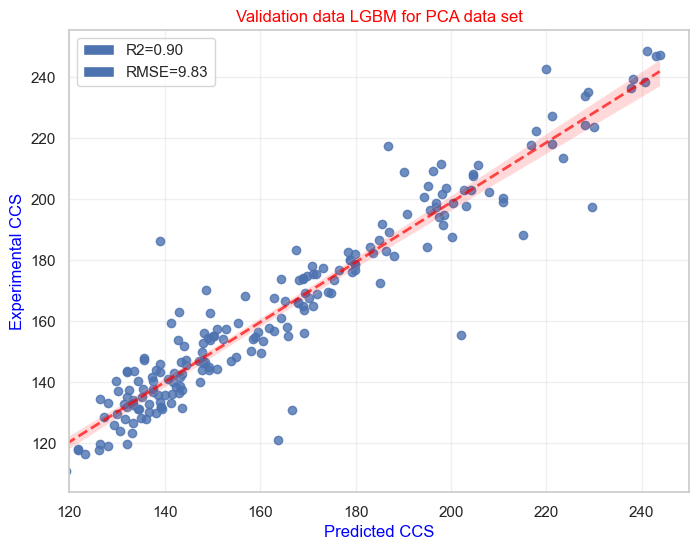

In [148]:
plot_data(y_valid_pca, y_preds_pca, "Validation data LGBM for PCA data set")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid_pca, 'Predicted Values': y_preds_pca})
data_to_save.to_csv('data_LGBM.csv', index=False)